# Prédiction de la note des vins

Le notebook compare plusieurs de modèles de régression.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = yn = df['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données.

In [4]:
from sklearn.preprocessing import normalize
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_norm = normalize(X)

Cette façon de faire est complètement erronnée car il est peu probable que la même normalisation soit apppliquée sur les trois bases. La normalisation doit être estimée sur la base d'apprentissage et appliquée sur la base de test. Reprenons.

In [5]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)
X_norm = norm.transform(X)

On récupère beaucoup de modèles implémentés dans *scikit-learn* pour la régression.

In [6]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.neural_network import *

models = [model for name, model in globals().items() if hasattr(model, 'fit') and \
                                                not hasattr(model, 'predict_proba') and \
                                                hasattr(model, '__name__') and \
                                                not model.__name__.endswith('CV') and \
                                                'Logistic' not in model.__name__ and \
                                                'Regr' in model.__name__]

import pprint
pprint.pprint(models)

[<class 'sklearn.linear_model._bayes.ARDRegression'>,
 <class 'sklearn.linear_model._huber.HuberRegressor'>,
 <class 'sklearn.linear_model._base.LinearRegression'>,
 <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>,
 <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>,
 <class 'sklearn.linear_model._theil_sen.TheilSenRegressor'>,
 <class 'sklearn.linear_model._ransac.RANSACRegressor'>,
 <class 'sklearn.ensemble._forest.RandomForestRegressor'>,
 <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>,
 <class 'sklearn.ensemble._bagging.BaggingRegressor'>,
 <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>,
 <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>,
 <class 'sklearn.ensemble._voting.VotingRegressor'>,
 <class 'sklearn.ensemble._stacking.StackingRegressor'>,
 <class 'sklearn.neighbors._regression.KNeighborsRegressor'>,
 <class 'sklearn.neighbors._regression.RadiusNeighborsRegressor'>,
 <class 'sklearn.neural_network._mul

In [7]:
from sklearn.metrics import r2_score

def score_model(xtr, xte, ytr, yte, model):
    try:
        model.fit(xtr, ytr)
    except Exception as e:
        raise Exception("Issue with model '{0}'".format(model.__name__)) from e
    return r2_score(yte, model.predict(xte))

In [8]:
from time import perf_counter 
r2s = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor', 'StackingRegressor'}:
        continue
    try:
        reg = model()
    except Exception as e:
        print('Skip', model)
        continue
    begin = perf_counter()
    r2 = score_model(X_train_norm, X_test_norm, y_train, y_test, reg)
    duree = perf_counter () - begin
    r2s.append(r2)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, duree)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1 HuberRegressor 0.1331298242827017 0.15339689999998996
2 LinearRegression 0.1573256134528277 0.0020869999999888478
3 PassiveAggressiveRegressor -1.1290380073648043 0.016268800000005967
4 SGDRegressor 0.00942520197661445 0.01098500000000513
5 TheilSenRegressor -0.32052255680753405 2.5255030000000147
6 RANSACRegressor -0.3170838352739842 0.08155489999998622
7 RandomForestRegressor 0.49628429226512505 3.491036400000013
8 ExtraTreesRegressor 0.5144853551208175 1.2391336999999965
9 BaggingRegressor 0.4221531756137368 0.3641057000000103
10 GradientBoostingRegressor 0.34358993163278395 1.5799150999999938
11 AdaBoostRegressor 0.22949392187370965 0.45730100000000107
14 KNeighborsRegressor 0.13454640232761572 0.03196189999999888
15 RadiusNeighborsRegressor -0.0019571433717924247 0.41475719999999683
16 MLPRegressor 0.19206563683555522 5.053024199999982


C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [9]:
import pandas
df = pandas.DataFrame(dict(model=names, r2=r2s, duree=durations))
df = df[['model', 'r2', 'duree']]
df.sort_values('r2')

,model,r2,duree
2,PassiveAggressiveRegressor,-1.129038,0.016269
4,TheilSenRegressor,-0.320523,2.525503
5,RANSACRegressor,-0.317084,0.081555
12,RadiusNeighborsRegressor,-0.001957,0.414757
3,SGDRegressor,0.009425,0.010985
0,HuberRegressor,0.133130,0.153397
11,KNeighborsRegressor,0.134546,0.031962
1,LinearRegression,0.157326,0.002087
13,MLPRegressor,0.192066,5.053024
10,AdaBoostRegressor,0.229494,0.457301


On filtre les valeurs inférieures à -1.

In [10]:
df = df[df.r2 >= -1]

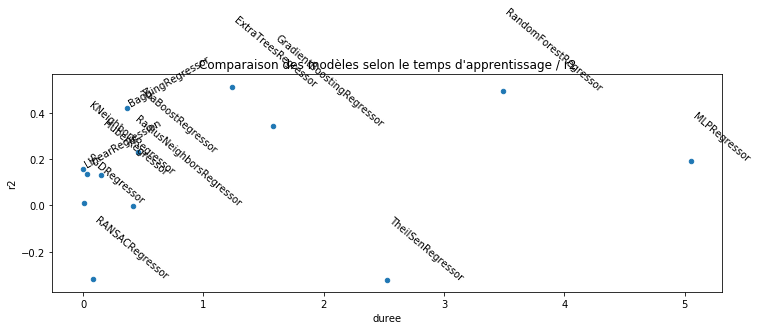

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, x = row[1:4]
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2");

L'estimateur [RANSACRegressor](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py) produit un $R^2$ très négatif. Regardons plus en détail.

In [12]:
pred = regressors['RANSACRegressor'].predict(X_test_norm)

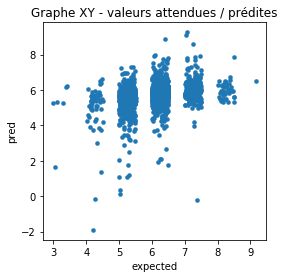

In [13]:
import numpy.random
df = pandas.DataFrame(dict(pred=pred, expected=y_test))
df['expected'] += numpy.random.random(df.shape[0]) * 0.5
ax = df.plot(x="expected", y="pred", kind='scatter', figsize=(4, 4), linewidths=0.1)
ax.set_title('Graphe XY - valeurs attendues / prédites');

Essayons de voir avec la densité.

c:\python372_x64\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


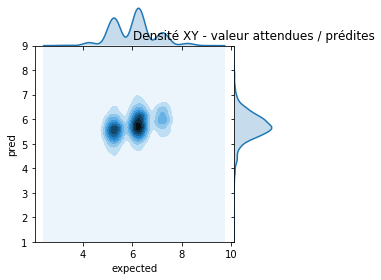

In [14]:
import seaborn
ax = seaborn.jointplot(df["expected"], df["pred"], kind="kde", size=4, space=0, ylim=(1, 9))
ax.ax_marg_y.set_title('Densité XY - valeur attendues / prédites');

Pas facile à voir. Essayons de voir autrement en triant les prédictions et les valeurs attendues par ordre.

In [15]:
sv = df.sort_values(['expected', 'pred']).reset_index(drop=True)

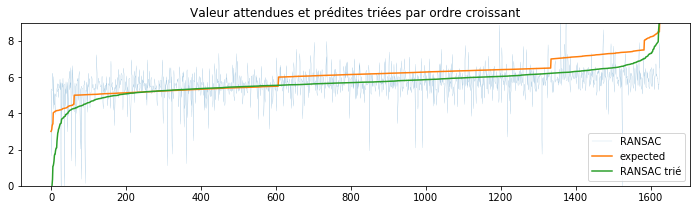

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sv["pred"], label="RANSAC", lw=0.1)
ax.plot(list(sorted(df["expected"])), label="expected")
ax.plot(list(sorted(df["pred"])), label="RANSAC trié")
ax.set_ylim([0, 9])
ax.set_title('Valeur attendues et prédites triées par ordre croissant')
ax.legend();

Le modèle est plutôt agité.

In [17]:
regressors['RANSACRegressor'].estimator_.intercept_

7.706891189056363

Pour s'assurer que les résultats sont fiables, il faut recommencer avec une validation croisée.

In [18]:
import numpy.random
rnd = numpy.random.permutation(range(X_norm.shape[0]))
xns = X_norm[rnd, :]
yns = yn[rnd]
xns.shape, yns.shape

((6497, 11), (6497,))

In [19]:
from sklearn.model_selection import cross_val_score

def score_model_cross(xn, yn, model):
    res = cross_val_score(model, xn, yn, cv=5)
    return res.mean(), min(res), max(res)

score_model_cross(xns, yns, LinearRegression())

(0.18161942093002995, 0.16804193929347955, 0.1934366433472421)

In [20]:
r2s = []
mis = []
mas = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor'}:
        continue
    try:
        reg = model()
    except Exception as e:
        print('Skip', model)
        continue
    begin = perf_counter()
    r2, mi, ma = score_model_cross(xns, yns, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    mis.append(mi)
    mas.append(ma)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, mi, ma, duree)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

1 HuberRegressor 0.16702239843843633 0.1502666729017369 0.17907788624903465 0.4765480999999454
2 LinearRegression 0.18161942093002995 0.16804193929347955 0.1934366433472421 0.015541999999982181
3 PassiveAggressiveRegressor -0.5111848289444161 -2.1975570757245584 -0.028146730070673698 0.06529689999996435
4 SGDRegressor 0.010684975047427003 -0.00011389082718982202 0.02179159983473733 0.04169619999998986
5 TheilSenRegressor -0.2993940940345943 -0.4916748315865094 -0.19447705078645305 14.191971799999976
6 RANSACRegressor -1.1239508858790601 -1.5834625569097973 0.015556368836057155 0.7375164999999697
7 RandomForestRegressor 0.49088230330712035 0.4791236241256115 0.5057058170549871 19.704109000000017
8 ExtraTreesRegressor 0.524927180807758 0.5109491696371715 0.5417123580995996 6.810633100000018
9 BaggingRegressor 0.44132356832705366 0.40912744650080024 0.46907864195365223 2.1305037999999854
10 GradientBoostingRegressor 0.3340940676763452 0.3051922143677225 0.34677502034659924 8.8758697999999

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

16 MLPRegressor 0.20947664520458975 0.19588866843377273 0.23572656734106778 26.435306199999957


C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
df = pandas.DataFrame(dict(model=names, r2=r2s, min=mis, max=mas, duree=durations))
df = df[['model', 'r2', 'min', 'max', 'duree']]
df.sort_values('r2')

,model,r2,min,max,duree
5,RANSACRegressor,-1.123951,-1.583463,0.015556,0.737516
2,PassiveAggressiveRegressor,-0.511185,-2.197557,-0.028147,0.065297
4,TheilSenRegressor,-0.299394,-0.491675,-0.194477,14.191972
12,RadiusNeighborsRegressor,-0.000514,-0.001362,0.000118,1.525845
3,SGDRegressor,0.010685,-0.000114,0.021792,0.041696
11,KNeighborsRegressor,0.165903,0.112287,0.200256,0.144910
0,HuberRegressor,0.167022,0.150267,0.179078,0.476548
1,LinearRegression,0.181619,0.168042,0.193437,0.015542
10,AdaBoostRegressor,0.205336,0.184791,0.221604,2.155397
13,MLPRegressor,0.209477,0.195889,0.235727,26.435306


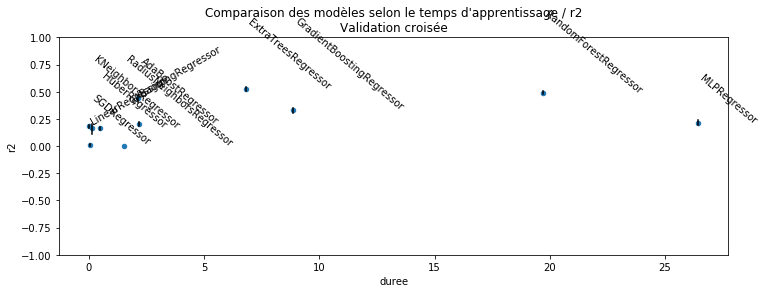

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df[df['min'] > -0.1].plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, mi, ma, x = row[1:6]
    if mi < -0.1:
        continue
    ax.plot([x, x], [mi, ma], color="black")
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_ylim([-1, 1])
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2\nValidation croisée");

Le modèle [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) est conçu pour apprendre un modèle linéaire et réduire l'ensemble d'apprentissage aux points non aberrants. Dans notre cas, vu le peu d'exemples pour les notes élevées, il est très probable que celles-ci disparaissent des observations choisies pour estimer le modèle : le modèle choisit d'évincer les exemples pour lesquels l'erreur est la plus grande en considérant que cela est une indication du fait qu'ils sont aberrants. Malgré cela, sa faible capacité à prévoir vient du fait que la majorité des vins ont une note entre 4 et 6 et que finalement, il y a peu de différences : ils sont tous moyens et la différence s'explique par d'autres facteurs comme le juge ayant donné la note.